# Challenge IMA 205


Student : BAHOUS YOUNESS

Used python version : 3.10.3

Used packeges versions

- Numpy version:  1.22.3
- Pandas version:  1.5.2
- OpenCV version:  4.7.0
- Nibabel version:  5.0.1
- cv2 version:  4.7.0
- sitk version:  2.2.1
- skimage version:  1.8.0
- sklearn version:  1.2.0

for the segmentation code check the colaboratory notebook : https://colab.research.google.com/drive/10kSd-qP1EfRPewxxI4_gK9HYZOfJpDKy?usp=sharing

In [29]:
import numpy as np

import matplotlib.pyplot as plt
import nibabel as nib
import pandas as pd
import cv2
import os


from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.utils import shuffle

from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import  cross_val_score
from sklearn.svm import SVC, LinearSVC
from sklearn.model_selection import GridSearchCV, KFold, cross_validate

# Compute volumes for each patient using sitk
import SimpleITK as sitk

from scipy import ndimage


In [54]:
print("cv2 version: ", cv2.__version__)
print("sitk version: ", sitk.Version_VersionString())
import scipy
print("skimage version: ", scipy.__version__)
import sklearn
print("sklearn version: ", sklearn.__version__)

cv2 version:  4.7.0
sitk version:  2.2.1
skimage version:  1.8.0
sklearn version:  1.2.0


In [30]:
# for reproducibility
np.random.seed(666)

## 1. Import the data

In [31]:
# Here a data loader is implemented to load the data from the folders
class NiiLoader:
    def __init__(self, data_path, labels_path, start_idx, end_idx):
        """
        data_path: path to the data folder
        labels_path: path to the labels csv file
        start_idx: start index of the data
        end_idx: end index of the data
        """
        
        self.data_path = data_path
        self.labels_path = labels_path
        self.start_idx = start_idx
        self.end_idx = end_idx
        self.num_samples = end_idx - start_idx + 1
        self.data_images = self.num_samples*2*[None]
        self.data_seg = self.num_samples*2*[None]
        
    def load_data(self):
        """
        Load the data and the labels
        return: meta data, labels, images, segmentations
        """
        # Load the labels
        meta = pd.read_csv(self.labels_path)
        labels = meta['Id'].values[self.start_idx-1:self.end_idx]
        
        # transform into string with 3 digits
        x = np.arange(self.start_idx, self.end_idx+1)
        x = np.char.mod('%03d', x)
        
        # load the data
        for i in x:
            idx = int(i) - self.start_idx
            self.data_images[idx*2] = nib.load(f"{self.data_path}/{i}/{i}_ED.nii")
            self.data_seg[idx*2] = nib.load(f"{self.data_path}/{i}/{i}_ED_seg.nii")
            self.data_images[idx*2+1] = nib.load(f"{self.data_path}/{i}/{i}_ES.nii")
            self.data_seg[idx*2+1] = nib.load(f"{self.data_path}/{i}/{i}_ES_seg.nii")
            
        return meta , labels, self.data_images, self.data_seg


# Load the train data
train_loader = NiiLoader(data_path="Train", labels_path="metaDataTrain.csv", start_idx=1, end_idx=100)
train_meta , train_labels, train_data_images, train_data_seg = train_loader.load_data()

# Load the test data
test_loader = NiiLoader(data_path="Test", labels_path="metaDataTest.csv", start_idx=101, end_idx=150)
test_meta , test_labels, test_data_images, test_data_seg = test_loader.load_data()

def normalize(data):
    # Normalize the data
    return (data - np.min(data)) / (np.max(data) - np.min(data))



In [32]:
# Saving the slices as images in to train and test folders

def saveSlice(data, path, name):
    data = np.uint8(data * 255)
    # Save the slice in the given path
    cv2.imwrite(f"{path}/{name}.png", data)

def saveSlices():
    # Save all the slices in in both dimensions
    for i in range(len(train_data_images)):
        for j in range(train_data_images[i].shape[2]):

            # save the normalized image
            saveSlice(normalize(train_data_images[i].get_fdata()[:,:,j]), "data/train/train_images/img", f"{i}_{j}")
            # save only the second segmented region
            #img = train_data_seg[i].get_fdata()[:,:,j] == 3
            #saveSlice(img*255, "data/train/train_seg/img", f"{i}_{j}")
            
    for i in range(len(test_data_images)):
        for j in range(test_data_images[i].shape[2]):
            saveSlice(normalize(test_data_images[i].get_fdata()[:,:,j]), "data/test/test_images/img", f"{i}_{j}")


In [7]:
# Getting spatial dimensions
hdr = train_data_images[0].header
voxel_volume = np.prod(hdr.get_zooms()[:3])

Notice that in all images the pixels have the same zooms in segmentations or images.

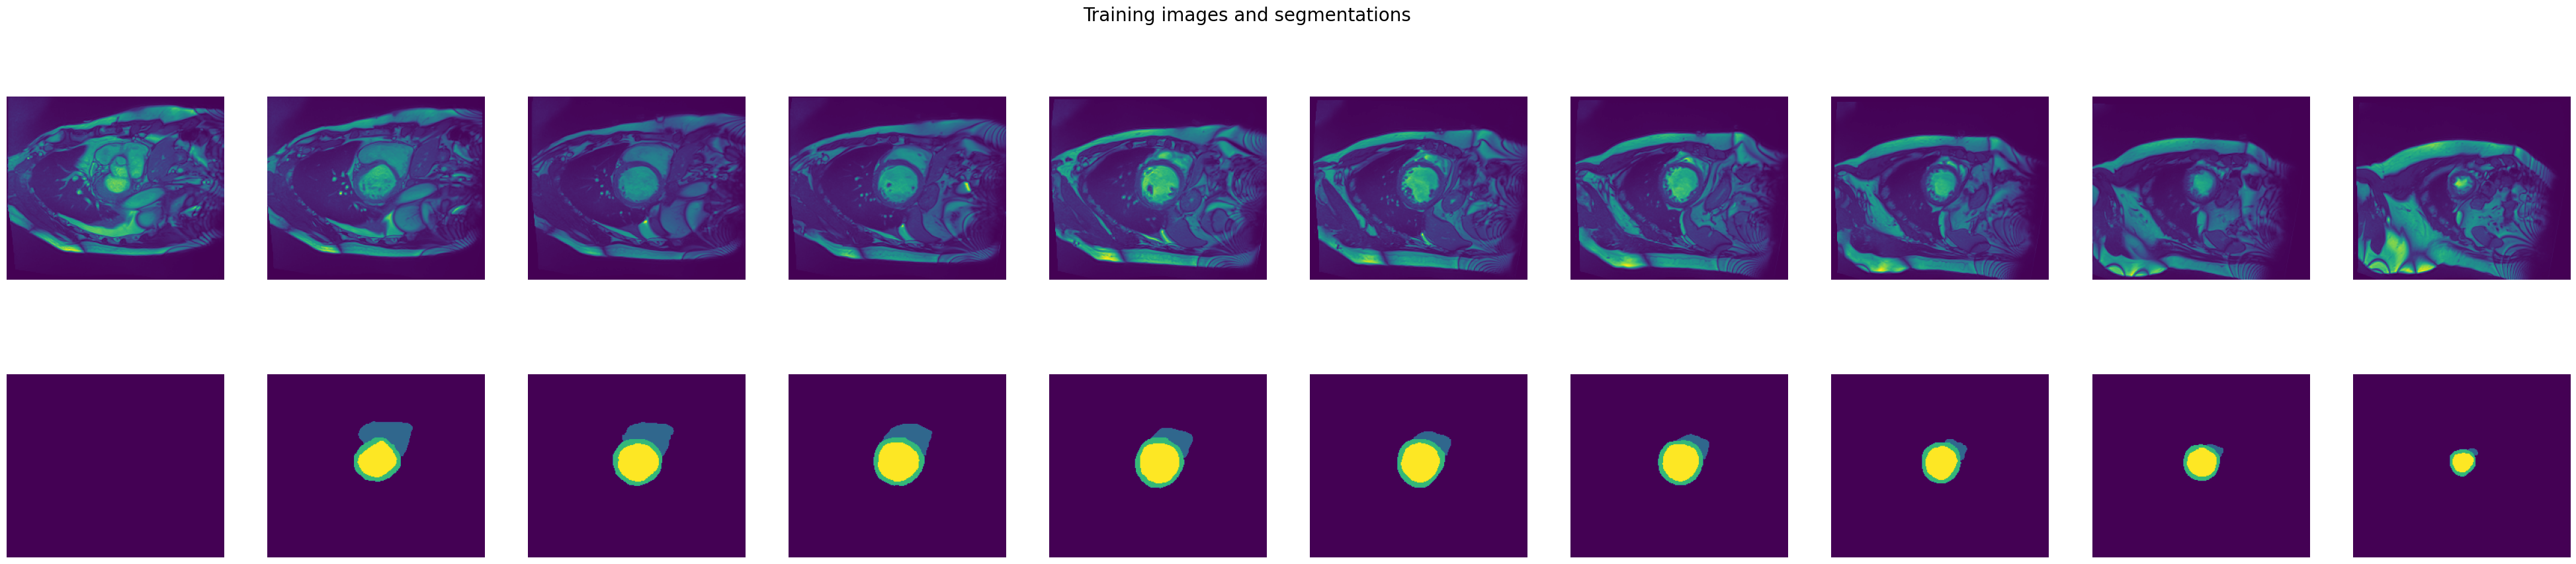

Training data shape:  (216, 256, 10)
Max value in the image:  658.0
Min value in the image:  0.0
Some Informations about the shapes: 
Size of the image:  (216, 256)
Size of the segmentation:  (216, 256)
Size of the image:  (256, 216)
Size of the segmentation:  (256, 216)


In [33]:
# Plot the images and segmentations side by side
plt.figure(figsize=(50,10))
plt.suptitle('Training images and segmentations', fontsize=20)

for i in range(10):
    # plot the image
    plt.subplot(2, 10, i+1)
    plt.imshow(train_data_images[0].get_fdata()[:,:,i])
    plt.axis('off')
    # plot the segmentation
    plt.subplot(2, 10, i+11)
    plt.imshow(train_data_seg[0].get_fdata()[:,:,i])
    plt.axis('off')
plt.savefig("images and segmentations.png", bbox_inches='tight', dpi=300)
plt.show()

print("Training data shape: ", train_data_images[0].shape)
print("Max value in the image: ", np.max(train_data_images[0].get_fdata()))
print("Min value in the image: ", np.min(train_data_images[0].get_fdata()))

# print shape
print("Some Informations about the shapes: ")
print("Size of the image: ", train_data_images[0].get_fdata()[:,:,0].shape)
print("Size of the segmentation: ", train_data_seg[0].get_fdata()[:,:,0].shape)
print("Size of the image: ", test_data_images[0].get_fdata()[:,:,0].shape)
print("Size of the segmentation: ", test_data_seg[0].get_fdata()[:,:,0].shape)


# Exporting the final results

In [34]:
# This function is to used at the end of the notebook to Export the predictions to a csv file
def save_results(y_pred):
    df = pd.read_csv('./SampleSubmission.csv')
    df['Category'] = y_pred
    df.to_csv('SampleSubmission.csv', index=False)

# Segementation of the data

Here from I use a Unet model to segment the data. 
The model is trained on the training data and then tested on the test data. The model is trained on 100 epochs and the best model is saved. The model is trained on a GPU on google colab.

In [38]:
import keras
# load the model
model = keras.models.load_model("model/modelunet.h5")

# change image size to fit the model input size and normalize the image

def reshape_image(image):
    out = cv2.resize(image, (256, 256) , interpolation = cv2.INTER_AREA)
    out = np.reshape(out, (1, 256, 256, 1))
    out = out / 255
    return out


def unet_segment(image):
    # reshape the image
    image = reshape_image(image)
    # predict the segmentation
    segmenation = model.predict(image , verbose=0)[0]
    # resize the segmentation to fit the original image
    segmenation = cv2.resize(segmenation, (image.shape[1], image.shape[2]) , interpolation = cv2.INTER_AREA)
    # tresold the segmentation
    segmenation = segmenation > 0.5
    return segmenation


#### Code for a very simple approximation of the segmentation - here since we have the segmentations of other regions - It is not used in the final results

Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.


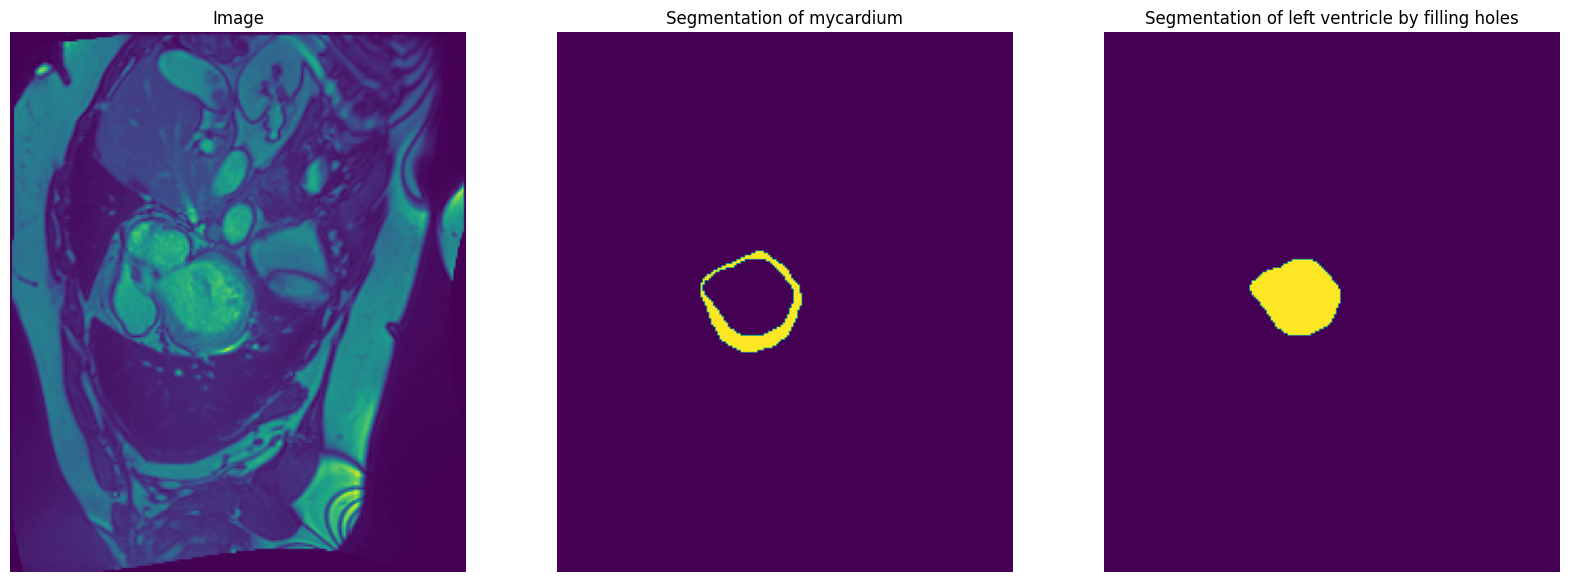

In [36]:
# Segment by filling the holes
def segmenation_by_filling_holes(image):
    imagec = image == 2
    # fill the holes with value 3
    imagefilled = ndimage.binary_fill_holes(imagec).astype(int)
    # remove the small objects
    return imagefilled - imagec
t = segmenation_by_filling_holes(test_data_seg[0].get_fdata()[:,:,0])


# plot the image the segmentation and the filled segmentation
plt.figure(figsize=(20,10))
plt.title("Segmentation by filling holes")
plt.subplot(1, 3, 1)
plt.imshow(test_data_images[0].get_fdata()[:,:,0])
plt.title("Image")
plt.axis('off')
plt.subplot(1, 3, 2)
plt.imshow(test_data_seg[0].get_fdata()[:,:,0])
plt.title("Segmentation of mycardium")
plt.axis('off')
plt.subplot(1, 3, 3)
plt.imshow(t)
plt.title("Segmentation of left ventricle by filling holes")
plt.axis('off')
plt.show()

# Feature extraction

In [37]:
def volume( mask_image ):
    # transform the image to sitk image
    mask_image = sitk.GetImageFromArray(mask_image.astype(np.uint8))
    label_shape_filter = sitk.LabelShapeStatisticsImageFilter()
    label_shape_filter.Execute(mask_image)
    vol = [label_shape_filter.GetPhysicalSize(i) for i in label_shape_filter.GetLabels()]

    return vol


volume(train_data_seg[0].get_fdata())

[5723.0, 6728.0, 12104.0]

# Feature extraction And Classification

In [46]:
M =50
N=100
# Volumes
my_vol_trainED , my_vol_trainES , my_vol_testED , my_vol_testES = N*[None] , N*[None] , M*[None] , M*[None]
rv_vol_trainED , rv_vol_trainES  , rv_vol_testED , rv_vol_testES  = N*[None] , N*[None] , M*[None] , M*[None]
lv_vol_trainED , lv_vol_trainES  , lv_vol_testED , lv_vol_testES  = N*[None] , N*[None] , M*[None] , M*[None]

# Ratios of volumes
rv_my_ratio_trainED , rv_my_ratio_trainES = N*[None] , N*[None]
rv_my_ratio_testED , rv_my_ratio_testES = M*[None] , M*[None]
lv_my_ratio_trainED , lv_my_ratio_trainES = N*[None] , N*[None]
lv_my_ratio_testED , lv_my_ratio_testES = M*[None] , M*[None]

# Ejection fractions for left ventricle
ef_train_lv , ef_test_lv = N*[None] , M*[None]

# ejection fraction for right ventricle
ef_train_rv , ef_test_rv = N*[None] , M*[None]





for i in range(N):
    
    # Compute volumes
    volumesES = volume(train_data_seg[2*i+1].get_fdata()) 
    volumesED = volume(train_data_seg[2*i].get_fdata())
    rv_vol_trainED[i] = volumesED[0]*voxel_volume
    rv_vol_trainES[i] = volumesES[0]*voxel_volume
    my_vol_trainED[i] = volumesED[1]*voxel_volume
    my_vol_trainES[i] = volumesES[1]*voxel_volume
    lv_vol_trainED[i] = volumesED[2]*voxel_volume
    lv_vol_trainES[i] = volumesES[2]*voxel_volume
    # compute ejection fraction
    ef_train_lv[i] = (lv_vol_trainED[i] - lv_vol_trainES[i])/lv_vol_trainED[i]
    ef_train_rv[i] = (rv_vol_trainED[i] - rv_vol_trainES[i])/rv_vol_trainED[i]

    # compute ratio between rv and my
    rv_my_ratio_trainED[i] = my_vol_trainES[i]/(rv_vol_trainES[i])
    rv_my_ratio_trainES[i] = my_vol_trainED[i]/(rv_vol_trainED[i])
    #compute ratio between lv and my
    lv_my_ratio_trainED[i] = my_vol_trainES[i]/(lv_vol_trainES[i])
    lv_my_ratio_trainES[i] = my_vol_trainED[i]/(lv_vol_trainED[i])


for i in range(M):

    # Compute volumes
    volumesES = volume(test_data_seg[2*i+1].get_fdata())
    volumesED = volume(test_data_seg[2*i].get_fdata())
    rv_vol_testED[i] = volumesED[0]*voxel_volume
    rv_vol_testES[i] = volumesES[0]*voxel_volume
    my_vol_testED[i] = volumesED[1]*voxel_volume
    my_vol_testES[i] = volumesES[1]*voxel_volume
    lv_vol_testED[i] = 0
    lv_vol_testES[i] = 0

    for j in range(test_data_seg[2*i].get_fdata().shape[2]):
        lv_vol_testED[i] += np.sum(unet_segment(test_data_images[2*i].get_fdata()[:,:,j])) * voxel_volume
        lv_vol_testES[i] += np.sum(unet_segment(test_data_images[2*i+1].get_fdata()[:,:,j])) * voxel_volume

    # compute ratio between rv and my
    rv_my_ratio_testED[i] = my_vol_testES[i]/(rv_vol_testES[i])
    rv_my_ratio_testES[i] = my_vol_testED[i]/(rv_vol_testED[i])
    #compute ratio between lv and my
    lv_my_ratio_testED[i] = my_vol_testES[i]/(lv_vol_testES[i])
    lv_my_ratio_testES[i] = my_vol_testED[i]/(lv_vol_testED[i])
    # compute ejection fraction
    ef_test_lv[i] = (lv_vol_testED[i] - lv_vol_testES[i])/lv_vol_testED[i]
    ef_test_rv[i] = (rv_vol_testED[i] - rv_vol_testES[i])/rv_vol_testED[i]


    
# are there any missing values?
print('Missing values in training data : {}'.format(np.sum(np.isnan(my_vol_trainED))))
print('Missing values in training data : {}'.format(np.sum(np.isnan(rv_vol_trainED))))
print('Missing values in training data : {}'.format(np.sum(np.isnan(my_vol_trainES))))
print('Missing values in training data : {}'.format(np.sum(np.isnan(rv_vol_trainES))))
print('Missing values in training data : {}'.format(np.sum(np.isnan(my_vol_testED))))
print('Missing values in training data : {}'.format(np.sum(np.isnan(rv_vol_testED))))
print('Missing values in training data : {}'.format(np.sum(np.isnan(rv_my_ratio_trainED))))
print('Missing values in training data : {}'.format(np.sum(np.isnan(rv_my_ratio_trainES))))
print('Missing values in training data : {}'.format(np.sum(np.isnan(lv_my_ratio_trainED))))
print('Missing values in training data : {}'.format(np.sum(np.isnan(lv_my_ratio_trainES))))
print('Missing values in training data : {}'.format(np.sum(np.isnan(rv_my_ratio_testED))))
print('Missing values in training data : {}'.format(np.sum(np.isnan(rv_my_ratio_testES))))
print('Missing values in training data : {}'.format(np.sum(np.isnan(lv_my_ratio_testED))))
print('Missing values in training data : {}'.format(np.sum(np.isnan(lv_my_ratio_testES))))
print('Missing values in training data : {}'.format(np.sum(np.isnan(ef_train_lv))))
print('Missing values in training data : {}'.format(np.sum(np.isnan(ef_test_lv))))
print('Missing values in training data : {}'.format(np.sum(np.isnan(ef_train_rv))))
print('Missing values in training data : {}'.format(np.sum(np.isnan(ef_test_rv))))





# Get the weights and height of the patients from the metadata
height_train = train_meta['Height'].values
weight_train = train_meta['Weight'].values
height_test = test_meta['Height'].values
weight_test = test_meta['Weight'].values


# use Mosteller formula to compute BSA
bsa_train = np.sqrt(height_train*weight_train/3600)
bsa_test = np.sqrt(height_test*weight_test/3600)



# Mass-index
mass_index_train = weight_train/height_train**2
mass_index_test = weight_test/height_test**2


# create the training and testing data
x_train = np.array([my_vol_trainED,
                    rv_vol_trainED,
                    my_vol_trainES,
                    rv_vol_trainES,
                    lv_vol_trainED,
                    lv_vol_trainES,
                    lv_my_ratio_trainED,
                    lv_my_ratio_trainES,
                    rv_my_ratio_trainED,
                    rv_my_ratio_trainES,
                    height_train,
                    weight_train,
                    bsa_train,
                    mass_index_train,
                    ef_train_lv,
                    ef_train_rv
                    ]).T

x_test = np.array([my_vol_testED,
                    rv_vol_testED,
                    my_vol_testES,
                    rv_vol_testES,
                    lv_vol_testED,
                    lv_vol_testES,
                    lv_my_ratio_testED,
                    lv_my_ratio_testES,
                    rv_my_ratio_testED,
                    rv_my_ratio_testES,
                    height_test,
                    weight_test,
                    bsa_test,
                    mass_index_test,
                    ef_test_lv,
                    ef_test_rv
                    ]).T


# load training results
y_train = train_meta['Category'].values

# shuffle the training data
x_train, y_train = shuffle(x_train, y_train, random_state=666)

Missing values in training data : 0
Missing values in training data : 0
Missing values in training data : 0
Missing values in training data : 0
Missing values in training data : 0
Missing values in training data : 0
Missing values in training data : 0
Missing values in training data : 0
Missing values in training data : 0
Missing values in training data : 0
Missing values in training data : 0
Missing values in training data : 0
Missing values in training data : 0
Missing values in training data : 0
Missing values in training data : 0
Missing values in training data : 0
Missing values in training data : 0
Missing values in training data : 0
[0. 1. 2. 3.]


## Classification method used

### Hyperparameters tuning with Random Forest :

In [50]:
# Random Forest
RF=RandomForestClassifier(random_state=666)
p_grid_RF = {'n_estimators': [50, 100, 200, 300, 400,500 , 600, 700 , 800 , 900 ,1000] ,
              'max_features': ['sqrt', 'log2'] ,
                'bootstrap': [True,False] }


grid_RF = GridSearchCV(RF, p_grid_RF, cv=5)
grid_RF.fit(x_train, y_train)
print("Best Validation Score: {}".format(grid_RF.best_score_))

print("Best params: {}".format(grid_RF.best_params_))
print('Training accuracy : {}'.format(grid_RF.score(x_train,y_train)))
yp= grid_RF.predict(x_test)
print(yp)
save_results(yp)

Best Validation Score: 0.96
Best params: {'bootstrap': True, 'max_features': 'sqrt', 'n_estimators': 400}
Training accuracy : 1.0
[2 4 0 3 4 1 0 0 4 4 3 3 4 0 0 4 2 3 1 0 4 0 3 3 1 2 1 4 2 4 1 4 3 2 0 0 2
 3 1 4 3 1 2 2 4 2 0 0 1 1]


# using shap values to explain the model

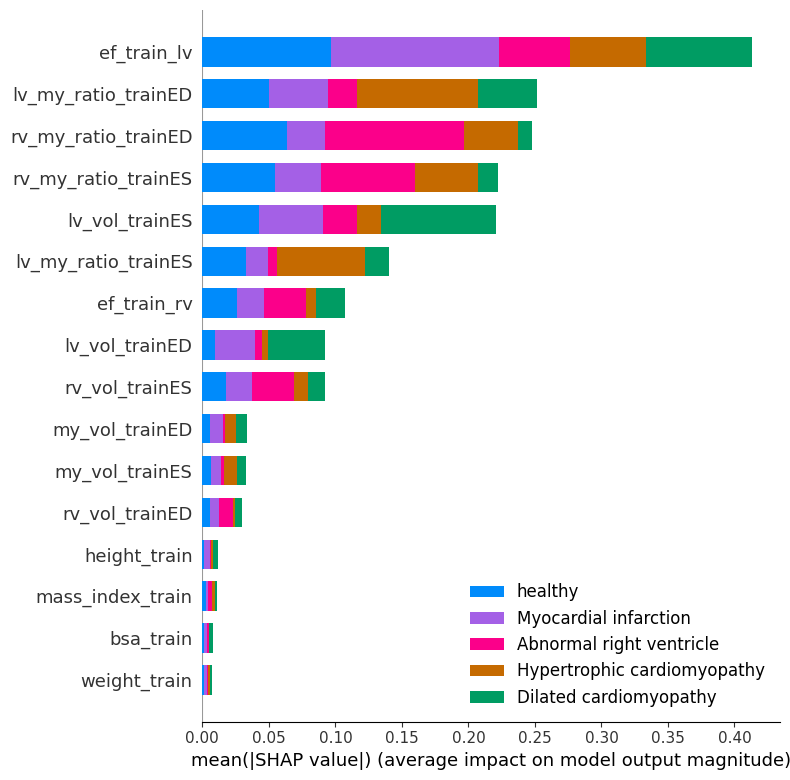

<Figure size 640x480 with 0 Axes>

In [51]:
# transform into dataframe for shap
X_train_shap = pd.DataFrame(x_train, columns = ['my_vol_trainED',
                    'rv_vol_trainED',
                    'my_vol_trainES',
                    'rv_vol_trainES',
                    'lv_vol_trainED',
                    'lv_vol_trainES',
                    'lv_my_ratio_trainED',
                    'lv_my_ratio_trainES',
                    'rv_my_ratio_trainED',
                    'rv_my_ratio_trainES',
                    'height_train',
                    'weight_train',
                    'bsa_train',
                    'mass_index_train',
                    'ef_train_lv',
                    'ef_train_rv'
                    ])
# Classes names 
classes = ['healthy', 'Myocardial infarction' , 'Dilated cardiomyopathy' , 'Hypertrophic cardiomyopathy' , 'Abnormal right ventricle']


import shap 
explainer = shap.TreeExplainer(grid_RF.best_estimator_)
shap_values = explainer.shap_values(X_train_shap)
shap.summary_plot(shap_values, X_train_shap , plot_type= "bar" , class_names = classes)
# save the figure
plt.savefig('shap_summary_plot.png', dpi=300, bbox_inches='tight')

In [ ]:
# code used for normalization and standardization to try svm for exemple
scaler = StandardScaler()
scaler.fit(x_train)
X_train = scaler.transform(x_train)
X_test = scaler.transform(x_test)